## EECS491 A3
### Tristan Maidment (tdm47)

#### Goal
The goal of to analyze relationships made in a large Bayesian Network.  For the purpose of this exercise, I will be using a free data set found online about car crash statistics.

In [1]:
from pgmpy.models import BayesianModel as bysmodel
from pgmpy.factors.discrete import TabularCPD as tcpd
import csv
import numpy as np
import itertools
from IPython.display import Image

#### Implementation
Seven binary variables will be taken from the database. Each entry in the database represents a single person in a crash.  The variables used are:


**K**illed - Whether or not the individual died in the crash.

**A**irbag - Whether or not the car has an airbag. (This dataset is fairly old, before airbags were a requirement)

**B**elt - Whether or not the individual was wearing their seatbelt.

**F**rontal - Whether or not the vehicle was hit in the front.

**S**ex - Gender of the individual.

**D**eploy - Whether or not the airbag was deployed.  Only true for cars with airbags.

**R**ole - Whether or the the individual was the driver or a passenger.


*The bolded letter represents the variable name used in code.*

In [2]:
k, a, b, f, s, d, r = [], [], [], [], [], [], []
with open('./crashes.csv') as csvfile:
    crashes = csv.reader(csvfile)
    for row in crashes:
        k.append(row[3]) #Killed
        a.append(row[4]) #Airbag
        b.append(row[5]) #Belt
        f.append(row[6]) #Front
        s.append(row[7]) #Sex
        r.append(row[12]) #Deply
        d.append(row[13]) #Role

##### Graph
In order to model the network, I have included a visual representation of the the model I being represented in this exercise.  Many of the variables require multiple evidence values.

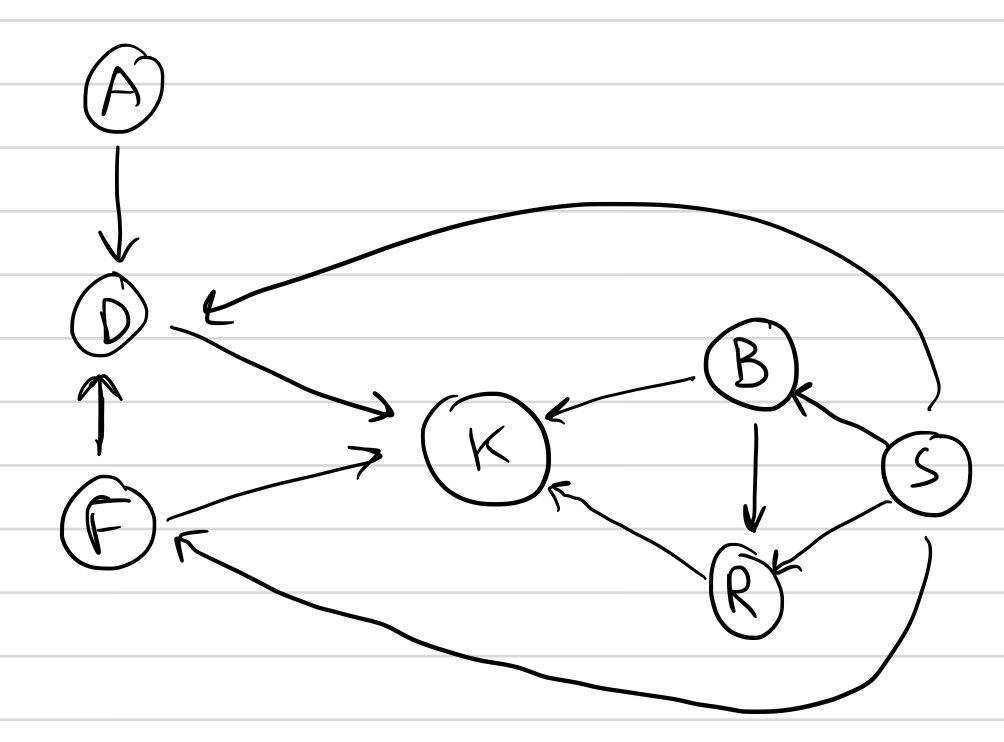

In [3]:
Image("./graph.png")

This function is used to determine the probability of a binary variable, with no evidence.  The reason there is a `true` and `false` parameter, instead of doing a noise or, for instance, is due to the fact that the data set has some errors within it.

In [4]:
def binary_prob(data, true, false):
    value, length = 0, 0
    for i in range(len(data)):
        if(data[i] == true):
            length += 1
            value += 1
        elif(data[i] == false):
            length += 1
    probability = value/length
    #print("Probability of",true,"is",probability)
    return probability

In [5]:
K = binary_prob(k, 'dead', 'alive')
print("Probability that a person dies in a crash: %.1f%%" % (K * 100))

Probability that a person dies in a crash: 4.5%


The second thing that we need to define is a function that can calculate the condition probability of a function given a variable amount of evidence variable.  `cond_prob` takes in the variable in question, and a list of evidence variables. The list needs to be formatted specifically, and the syntax is shown as a comment.

In [6]:
#(var, "false", "true"), ((ev1, "false", "true"),(ev2, "false", "true"))
def cond_prob(data, args):
    #print(args)
    value, length, arg_len = 0, 0, len(args)
    for i in range(len(data[0])):
        if(data[0][i] == data[1]):
            conds = 0
            for arg in range(arg_len):
                if(len(args[arg]) % 3 != 0):
                    print("INCORRECT NUMBER OF ARGS")
                if(args[arg][0][i] == args[arg][1]):
                    length += 1
                    conds += 1
                elif(args[arg][0][i] == args[arg][2]):
                    length +=1
            if(conds == arg_len):
                value += 1
    probability = value/length
    return probability

In [7]:
D_A = cond_prob([d, '1', '0'], [[f, '1', '0'], [a, 'airbag', 'none']])
print("Prob of airbag deployment, given the car has an airbag, and the crash was frontal: %.1f%%" % (K * 100))


Prob of airbag deployment, given the car has an airbag, and the crash was frontal: 4.5%


`tcpd` requires that the conditional probability values be insert in a certain order.  To the input of these values easier, this function was designed to properly format the value of each cpd.

Due to the nature of the inputs, it requires a binary counter to ensure that the order of inputs is correct.

In [8]:
def create_values(var, evidence):
    ev_len = len(evidence)
    #print("num args",ev_len)
    width = 2**ev_len
    layout = []
    for i in itertools.product([0,1],repeat=ev_len + 1):
        layout.append(i)
    #print(layout[::-1]) #reverse the list
    #print(layout)
    #print(evidence)
    values = np.empty((2, width))
    for i in range(2):
        for j in range(width):
            comb = layout[width*i + j]
            ev_val = []
            for k in range(ev_len):
                ev_list = []
                ev_list.append(evidence[k][0])
                ev_list.append(evidence[k][comb[k+1] + 1])
                ev_list.append(evidence[k][2 - comb[k+1]])
                ev_val.append(ev_list)
            values[i, j] = cond_prob((var[0], var[comb[0] + 1], var[comb[0]]), ev_val)
    values[0,:] = 1-values[1,:] # make sure probabilities = 1
    return values

A test of this function is shown below.  This is the correct format for the input of the data to the model.

In [9]:
values = create_values([f, "0", "1"], [[s, "f", "m"]])
print(values)

[[0.55573343 0.44426657]
 [0.44426657 0.55573343]]


##### Model
The next step is to define the model.  Each connection in the graph define earlier must be included in the models definition.

In [10]:
model = bysmodel([('A', 'D'), ('F', 'D'), ('F', 'K'), ('D', 'K'),
                 ('B', 'K'), ('R', 'K'), ('B', 'R'), ('S', 'B'),
                 ('S', 'R'), ('S', 'D'), ('S', 'F')])

In addition, the variables must be defined.  Variables that are based on some evidence must be defined as such at this point.

In [11]:
priorA = tcpd(variable='A', variable_card=2, values=[[binary_prob(a, 'airbag', 'none'), binary_prob(a, 'none', 'airbag')]])
priorS = tcpd(variable='S', variable_card=2, values=[[binary_prob(s, 'm', 'f'), binary_prob(s, 'f', 'm')]])

cpdF = tcpd(variable='F', variable_card=2, 
            evidence=['S'], evidence_card=[2], 
            values=create_values([f, "0", "1"], [[s, "f", "m"]]))

cpdK = tcpd(variable='K', variable_card=2, 
            evidence=['D', 'F', 'B', 'R'], evidence_card=[2, 2, 2, 2], 
            values=create_values([k, "alive", "dead"], [[d, "0", "1"], [f, "0", "1"], [b, "none", "belted"], [r, "pass", "driver"]]))
cpdB = tcpd(variable='B', variable_card=2, 
            evidence=['S'], evidence_card=[2], 
            values=create_values([b, "none", "belted"], [[s, "f", "m"]]))

cpdD = tcpd(variable='D', variable_card=2, 
            evidence=['S', 'A', 'F'], evidence_card=[2, 2, 2], 
            values=create_values([d, "0", "1"], [[s, "f", "m"],[a, "none", "airbag"],[f, "0", "1"]]))

cpdR = tcpd(variable='R', variable_card=2, 
            evidence=['S', 'B'], evidence_card=[2, 2], 
            values=create_values([r, "pass", "driver"], [[s, "f", "m"],[b,"none","belted"]]))

Then, the model must be checked for consistency.

In [12]:
model.add_cpds(priorA, priorS, cpdF, cpdK, cpdB, cpdR, cpdD)
model.check_model()

True

### Analysis
We will be using a variety of methods to execute inference on the network.
The first method being tested is `Variable Elimination`

#### Variable Elimination

In [13]:
from pgmpy.inference import VariableElimination

VESolver = VariableElimination(model)

In [14]:
print('Deployed|Killed,WearingBelt : %.1f%%' % (VESolver.query(['D'], evidence={'K' : 1, 'B' : 1})['D'].values[1] * 100))
print('Driver|Killed,WearingBelt  : %.1f%%' % (VESolver.query(['R'], evidence={'K' : 1, 'B' : 1})['R'].values[1] * 100))
print('Frontal|Killed,Deployed   : %.1f%%' % (VESolver.query(['F'], evidence={'K' : 1, 'D' : 1})['F'].values[1] * 100))

Deployed|Killed,WearingBelt : 1.5%
Driver|Killed,WearingBelt  : 36.0%
Frontal|Killed,Deployed   : 79.5%


Another method for exact inference is Belief Propegation.  We get the exact same answers as `Belief Propegation`, indicating that the model is consistent and the methods work properly.

#### Belief Propegation

In [15]:
from pgmpy.inference import BeliefPropagation

BPSolver = BeliefPropagation(model)

In [16]:
BPSolver.calibrate()

In [17]:
print('Deployed|Killed,WearingBelt : %.1f%%' % (BPSolver.query(['D'], evidence={'K' : 1, 'B' : 1})['D'].values[1] * 100))
print('Driver|Killed,WearingBelt  : %.1f%%' % (BPSolver.query(['R'], evidence={'K' : 1, 'B' : 1})['R'].values[1] * 100))
print('Frontal|Killed,Deployed   : %.1f%%' % (BPSolver.query(['F'], evidence={'K' : 1, 'D' : 1})['F'].values[1] * 100))

Deployed|Killed,WearingBelt : 1.5%
Driver|Killed,WearingBelt  : 36.0%
Frontal|Killed,Deployed   : 79.5%


#### Bayesian Model Sampling

In [18]:
from pgmpy.factors.discrete import State
from pgmpy.sampling import BayesianModelSampling

SMPSolver = BayesianModelSampling(model)

nsamples = 100
evdKB  = [State('K', 1), State('B', 1)]
smpKB  = SMPSolver.rejection_sample(evidence=evdKB, size=nsamples)
evdKD = [State('K', 1), State('D', 1)]
smpKD = SMPSolver.rejection_sample(evidence=evdKD, size=nsamples)

In [19]:
from pandas.core.frame import DataFrame

def calcCondProb(trace, event, cond):
    if type(trace) is DataFrame:
        trace = trace.transpose().to_dict().values()
    # find all samples satisfy conditions
    for k, v in cond.items():
        trace = [smp for smp in trace if smp[k] == v]
    # record quantity of all samples fulfill condition
    nCondSample = len(trace)
    # find all samples satisfy event
    for k, v in event.items():
        trace = [smp for smp in trace if smp[k] == v]
    # calculate conditional probability
    return len(trace) / nCondSample

In [20]:
print('Deployed|Killed,WearingBelt  : %.1f%%' % (calcCondProb(smpKB, {'D' : 1}, {}) * 100))
print('Driver|Killed,WearingBelt  : %.1f%%' % (calcCondProb(smpKB, {'R' : 1}, {}) * 100))
print('Frontal|Killed,Deployed  : %.1f%%' % (calcCondProb(smpKD, {'F' : 1}, {}) * 100))

Deployed|Killed,WearingBelt  : 1.0%
Driver|Killed,WearingBelt  : 42.0%
Frontal|Killed,Deployed  : 79.0%


Note that my computer is *especially slow* when sampling this model.  For that reason I only use 100 samples when printing this notebook.  With more samples, the probabilities will converge toward the true value.  With 100 samples, this process took a whopping 6 minutes.

### Conclusion
Overall, the implementation of a variety of inference methods on a Bayesian Network was fairly straightforward once the model was defined.  Due to how the package is designed, creating such a model takes a majority of the time, and analysis is fairly straightforward. For models similar to the size of the one defined, exact inference is a fairly fast method, and sampling takes a fair bit longer.  However, for larger models, sampling should be faster.